In [1]:
import argparse
import numpy as np
import pandas as pd
import os
import random
import torch
import torch.nn as nn
import datetime
import time
import matplotlib.pyplot as plt
from torchinfo import summary
import yaml
import json
import sys
import glob
import copy
from tqdm import tqdm, trange

In [2]:
sys.path.append("..")
from lib.utils import (
    MaskedMAELoss,
    MaskedHuberLoss,
    print_log,
    seed_everything,
    set_cpu_num,
    masked_mae_loss,
    CustomJSONEncoder,
)
from lib.metrics import RMSE_MAE_MAPE
from lib.data_prepare import get_dataloaders_from_index_data, load_inrix_data_with_details
from model.STGformer import STGformer

/home/dachuan/anaconda3/envs/deep/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATASET = "INRIX_Manhattan"
MODE = 'test'
DEVICE = 'cuda:1'
SHIFT = True
SCALER = None

In [4]:
@torch.no_grad()
def inference_graph(model):
    graph = torch.matmul(model.adaptive_embedding, model.adaptive_embedding.transpose(1, 2))
    graph = model.pooling(graph.transpose(0, 2)).transpose(0, 2)
    graph = nn.functional.relu(graph)
    graph = nn.functional.softmax(graph, dim=-1)
    return graph

def eval_model(model, valset_loader, criterion):
    model.eval()
    batch_loss_list = []
    for x_batch, y_batch in valset_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        out_batch = model(x_batch)
        out_batch = SCALER.inverse_transform(out_batch)
        loss = criterion(out_batch, y_batch)
        batch_loss_list.append(loss.item())

    return np.mean(batch_loss_list)


@torch.no_grad()
def predict(model, loader):
    model.eval()
    y = []
    out = []

    for x_batch, y_batch in tqdm(loader):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        out_batch = model(x_batch)
        out_batch = SCALER.inverse_transform(out_batch)

        out_batch = out_batch.cpu().numpy()
        y_batch = y_batch.cpu().numpy()
        out.append(out_batch)
        y.append(y_batch)
    _, _, num_nodes, _ = out_batch.shape
    out = np.vstack(out).reshape(-1, 1, num_nodes)  # (samples, out_steps, num_nodes)
    y = np.vstack(y).reshape(-1, 1, num_nodes)

    return y, out

@torch.no_grad()
def test_model(model, testset_loader, log=None):
    model.eval()
    print_log("--------- Test ---------", log=log)

    start = time.time()
    y_true, y_pred = predict(model, testset_loader)
    end = time.time()

    rmse_all, mae_all, mape_all = RMSE_MAE_MAPE(y_true, y_pred)
    out_str = "All Steps RMSE = %.5f, MAE = %.5f, MAPE = %.5f\n" % (
        rmse_all,
        mae_all,
        mape_all,
    )
    # print (f"--- y_true: {y_true.shape}  y_pred: {y_pred.shape} ---")
    out_steps = y_pred.shape[1]
    for i in range(out_steps):
        rmse, mae, mape = RMSE_MAE_MAPE(y_true[:, i, :], y_pred[:, i, :])
        out_str += "Step %d RMSE = %.5f, MAE = %.5f, MAPE = %.5f\n" % (
            i + 1,
            rmse,
            mae,
            mape,
        )

    print_log(out_str, log=log, end="")
    print_log("Inference time: %.2f s" % (end - start), log=log)

In [10]:
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from scipy.spatial import cKDTree  # if you don't have SciPy, see fallback note below

def _line_endpoints(line):
    """Return a list of endpoints [(x1,y1),(x2,y2)] for a LineString/MultiLineString."""
    if line.is_empty:
        return []
    if isinstance(line, LineString):
        coords = list(line.coords)
        if len(coords) < 2:
            return []
        return [coords[0], coords[-1]]
    elif isinstance(line, MultiLineString):
        # take endpoints of each part (dedupe later)
        pts = []
        for part in line.geoms:
            if part.length > 0:
                c = list(part.coords)
                pts.extend([c[0], c[-1]])
        # deduplicate very-close endpoints inside a multilinestring
        if not pts:
            return []
        pts = np.array(pts)
        # simple dedupe with rounding to 1e-6 map units (safe after projecting to meters)
        uniq, idx = np.unique(np.round(pts, 6), axis=0, return_index=True)
        pts = pts[np.sort(idx)]
        return [tuple(p) for p in pts[:2]] if len(pts) >= 2 else [tuple(pts[0])]
    else:
        return []

def endpoint_adjacency(
    roads_gdf: gpd.GeoDataFrame,
    d: float = 20.0,
    crs_metric: str | None = None,
    id_col: str | None = None,
    return_sparse: bool = False,
):
    """
    Build an NxN binary adjacency where entry[i,j]=1 if any endpoint of link i
    is within distance d (meters) of any endpoint of link j.

    Parameters
    ----------
    roads_gdf : GeoDataFrame of LineString/MultiLineString
    d         : float, distance threshold in meters
    crs_metric: str or EPSG code. If provided (recommended), reprojects to this metric CRS.
                If None, assumes the GeoDataFrame is already in a metric CRS.
    id_col    : optional column with stable link IDs. If None, uses row order [0..N-1].
    return_sparse : if True, returns a scipy.sparse.csr_matrix; else returns a dense np.uint8 array.

    Returns
    -------
    A : (N,N) adjacency (csr_matrix or np.ndarray)
    index_to_id : list mapping row index -> link id (if id_col given, otherwise same as index)
    """
    # 1) project to meters if requested
    g = roads_gdf.copy()
    if crs_metric is not None:
        g = g.to_crs(crs_metric)

    # 2) establish link index <-> id
    if id_col is not None and id_col in g.columns:
        link_ids = list(g[id_col].values)
    else:
        link_ids = list(range(len(g)))
    N = len(link_ids)

    # 3) collect endpoints (2 per link, but may be fewer if geometry invalid/degenerate)
    ep_coords = []          # shape (~2N, 2)
    ep_link_idx = []        # which link this endpoint belongs to
    for i, geom in enumerate(g.geometry.values):
        if geom is None or geom.is_empty:
            continue
        pts = _line_endpoints(geom)
        # keep at most 2 endpoints per link; if only one found (degenerate), keep it
        for p in pts[:2]:
            ep_coords.append(p)
            ep_link_idx.append(i)

    if len(ep_coords) == 0:
        # no endpoints -> empty adjacency
        if return_sparse:
            from scipy.sparse import csr_matrix
            return csr_matrix((N, N), dtype=np.uint8), link_ids
        else:
            return np.zeros((N, N), dtype=np.uint8), link_ids

    ep_coords = np.asarray(ep_coords, dtype=float)
    ep_link_idx = np.asarray(ep_link_idx, dtype=int)

    # 4) radius search over endpoints
    tree = cKDTree(ep_coords)
    # For each endpoint index u, find all endpoint indices v within d
    # query_ball_point returns variable-length lists per u
    nbrs = tree.query_ball_point(ep_coords, r=d)

    # 5) fill adjacency using (link_u, link_v) from endpoint pairs
    if return_sparse:
        from scipy.sparse import coo_matrix
        rows, cols = [], []
        for u, vs in enumerate(nbrs):
            lu = ep_link_idx[u]
            for v in vs:
                lv = ep_link_idx[v]
                if lu == lv:
                    continue  # skip self
                rows.append(lu)
                cols.append(lv)
        if rows:
            data = np.ones(len(rows), dtype=np.uint8)
            A = coo_matrix((data, (rows, cols)), shape=(N, N), dtype=np.uint8).tocsr()
            # make symmetric (undirected) and zero diagonal
            A = ((A + A.T) > 0).astype(np.uint8)
            A.setdiag(0)
            A.eliminate_zeros()
        else:
            from scipy.sparse import csr_matrix
            A = csr_matrix((N, N), dtype=np.uint8)
        return A, link_ids
    else:
        A = np.zeros((N, N), dtype=np.uint8)
        for u, vs in enumerate(nbrs):
            lu = ep_link_idx[u]
            for v in vs:
                lv = ep_link_idx[v]
                if lu == lv:
                    continue
                A[lu, lv] = 1
                A[lv, lu] = 1
        np.fill_diagonal(A, 0)
        return A, link_ids


In [6]:
seed = random.randint(0,1000)  # set random seed here
seed_everything(seed)
set_cpu_num(1)

In [7]:
path_to_Weight = '../saved_models/STGformer-INRIX_MANHATTAN-2025-09-29-09-19-43.pt'

In [8]:
dataset = DATASET.upper()
data_path = f"../data/{dataset}"

model_name = STGformer.__name__

with open(f"{model_name}.yaml", "r") as f:
    cfg = yaml.safe_load(f)
cfg = cfg[dataset]

# ------------------------------- make log file ------------------------------ #

now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
log_path = f"../logs/"
if not os.path.exists(log_path):
    os.makedirs(log_path)
log = os.path.join(log_path, f"{model_name}-{dataset}-{now}.log")
log = open(log, "a", encoding="utf-8")
log.seek(0)
log.truncate()

# ------------------------------- load dataset ------------------------------- #

print_log(dataset, log=log)
    
(trainset_loader, valset_loader, testset_loader, SCALER, adj_mx, gdf, tmc) = (
    load_inrix_data_with_details(
        "/home/dachuan/Productivities/Spectral GAT/NY/adj_manhattan.npy",
        "/home/dachuan/Productivities/Spectral GAT/SPGAT/Data/speed_19_Manhattan_5min_py36",
        "/home/dachuan/Productivities/Spectral GAT/NY/Manhattan_FinalVersion.shp",
        "/home/dachuan/Productivities/Spectral GAT/NY/TMC_FinalVersion.csv",
        tod=cfg.get("time_of_day"),
        dow=cfg.get("day_of_week"),
        batch_size=cfg.get("batch_size", 64),
        history_seq_len=cfg.get("in_steps"),
        future_seq_len=cfg.get("out_steps"),
        log=log,
        train_ratio=cfg.get("train_size", 0.6),
        valid_ratio=cfg.get("val_size", 0.2),
        shift=SHIFT,
    )
)


print_log(log=log)
supports = [torch.tensor(i).to(DEVICE) for i in adj_mx]

INRIX_MANHATTAN
--- Building Sequences ---
--- Scaling Sequences ---
Trainset:	x-(63057, 1212, 12, 1)	y-(63057, 1212, 1, 1)
Valset:  	x-(21019, 1212, 12, 1)  	y-(21019, 1212, 1, 1)
Testset:	x-(21020, 1212, 12, 1)	y-(21020, 1212, 1, 1)



In [9]:
import torch
from typing import Iterable, Sequence, Tuple, Optional

# -------------------- helpers --------------------

@torch.no_grad()
def _compute_train_node_stats_from_loader(
    trainset_loader: Iterable[Tuple[torch.Tensor, torch.Tensor]],
    scaler,
    device: torch.device | str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    total_sum = None
    total_sumsq = None
    total_count = 0

    for batch_x, batch_y in trainset_loader:
        bx = batch_x.to(device)                # (B, T_h, N, C)
        by = batch_y.to(device)                # (B, T_f, N, C)
        bx_raw = scaler.inverse_transform(bx)  # (B, T_h, N, C)
        raw = torch.cat([bx_raw, by], dim=1).squeeze(-1)  # (B, T, N)

        B, T, N = raw.shape
        flat = raw.reshape(B*T, N)
        s  = flat.sum(dim=0)
        ss = (flat * flat).sum(dim=0)

        if total_sum is None:
            total_sum, total_sumsq = s.clone(), ss.clone()
        else:
            total_sum  += s
            total_sumsq += ss
        total_count += B*T

    mu  = total_sum / max(total_count, 1)
    var = (total_sumsq / max(total_count, 1)) - mu*mu
    var = torch.clamp(var, min=0.0)
    std = torch.sqrt(var + 1e-8)
    return mu.float(), std.float()


def _rectified_channels_from_dv(x_z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    dv = torch.diff(x_z, dim=1, prepend=x_z[:, :1, :])  # (B,T,N)
    r = torch.relu(-dv)   # reductions (down moves)
    u = torch.relu( dv)   # increases (up moves)
    return r, u


def _xcorr_positive_lags_allpairs(
    chan: torch.Tensor,
    lags: Sequence[int],
    eps: float = 1e-8
) -> torch.Tensor:
    """
    chan: (B,T,N) one rectified channel
    Returns rho: (B,L,N,N) where for lag ℓ we correlate chan[:, :T-ℓ, i] with chan[:, ℓ:, j]
    """
    B, T, N = chan.shape
    L = len(lags)
    out = chan.new_zeros((B, L, N, N))

    for li, LAG in enumerate(lags):
        if LAG <= 0 or LAG >= T:
            continue
        A  = chan[:, :T-LAG, :]     # (B,Tl,N)
        B_ = chan[:,  LAG:,  :]     # (B,Tl,N)
        Tl = A.shape[1]

        A_c = A - A.mean(dim=1, keepdim=True)
        B_c = B_ - B_.mean(dim=1, keepdim=True)

        A_std = torch.sqrt(A_c.pow(2).mean(dim=1) + eps)   # (B,N)
        B_std = torch.sqrt(B_c.pow(2).mean(dim=1) + eps)   # (B,N)

        cov = torch.matmul(A_c.transpose(1, 2), B_c) / max(Tl - 1, 1)  # (B,N,N)
        denom = (A_std.unsqueeze(-1) * B_std.unsqueeze(1)).clamp_min(eps)
        out[:, li] = cov / denom
    return out


def _maybe_to_sparse(x: torch.Tensor, sparse: bool) -> torch.Tensor:
    if not sparse:
        return x
    # Ensure float dtype for masks, too (0/1)
    if x.dtype != torch.float32 and x.dtype != torch.float64:
        x = x.float()
    return x.to_sparse()


# -------------------- main API --------------------

@torch.no_grad()
def compute_batchwise_ccf_two_channels_from_loader(
    trainset_loader: Iterable[Tuple[torch.Tensor, torch.Tensor]],
    lags: Sequence[int],
    scaler,
    device: torch.device | str = "cpu",
    A_mask: Optional[torch.Tensor] = None,             # (N,N) 1=physically connected
    phys_thresholds: Tuple[float, float] = (0.2, 0.5), # (τ_lo, τ_hi)
    sparse: bool = True
):
    """
    Yields per batch a 6-tuple:
      (rho_red,  sig_red,  band_red,
       rho_up,   sig_up,   band_up)

    Shapes (dense):
      each is (B, L, N, N)

    - A_mask (N,N): if provided, masks all three outputs per channel (elementwise multiply).
      You control self-loops by A_mask diagonal (1 allow / 0 forbid).
    - phys_thresholds = (τ_lo, τ_hi):
        * significance mask: (ρ > τ_hi)  → 1 else 0
        * band_mask: 0 if τ_lo < ρ < τ_hi (mid-band), else 1
    - sparse=True returns all tensors as sparse COO.
    """
    assert len(lags) > 0, "Provide at least one positive lag."
    tau_lo, tau_hi = phys_thresholds
    assert tau_lo < tau_hi, "Require tau_lo < tau_hi."

    # compute per-node stats on raw speeds
    mu, std = _compute_train_node_stats_from_loader(trainset_loader, scaler, device)

    # Prepare broadcastable A_mask if given
    if A_mask is not None:
        A_mask = A_mask.to(device=device).bool()  # (N,N)
        # For broadcasting over (B,L,N,N):
        def _apply_phys_mask(x: torch.Tensor) -> torch.Tensor:
            return x * A_mask.view(1, 1, *A_mask.shape)
    else:
        def _apply_phys_mask(x: torch.Tensor) -> torch.Tensor:
            return x

    # Second pass: compute per-batch outputs
    for batch_x, batch_y in trainset_loader:
        bx = batch_x.to(device)                # (B, T_h, N, C)
        by = batch_y.to(device)                # (B, T_f, N, C)
        bx_raw = scaler.inverse_transform(bx)  # -> raw speeds
        raw = torch.cat([bx_raw, by], dim=1).squeeze(-1)  # (B, T, N)

        B, T, N = raw.shape
        x_z = (raw - mu.view(1, 1, N)) / std.view(1, 1, N)  # z-score per node
        r, u = _rectified_channels_from_dv(x_z)             # (B,T,N) each

        # Correlations per lag
        rho_red = _xcorr_positive_lags_allpairs(r, lags)    # (B,L,N,N)
        rho_up  = _xcorr_positive_lags_allpairs(u, lags)

        # Apply physical mask to correlations
        rho_red = _apply_phys_mask(rho_red)
        rho_up  = _apply_phys_mask(rho_up)

        # Threshold-based masks
        # significance: 1 where rho > τ_hi
        sig_red  = (rho_red > tau_hi).float()
        sig_up   = (rho_up  > tau_hi).float()

        # band_mask: 0 if τ_lo < rho < τ_hi, else 1
        mid_red  = ((rho_red > tau_lo) & (rho_red < tau_hi)).float()
        band_red = (1.0 - mid_red)  # zero in mid-band, one otherwise

        mid_up   = ((rho_up  > tau_lo) & (rho_up  < tau_hi)).float()
        band_up  = (1.0 - mid_up)

        # Apply physical mask to masks as well (to zero any forbidden pairs)
        sig_red  = _apply_phys_mask(sig_red)
        band_red = _apply_phys_mask(band_red)
        sig_up   = _apply_phys_mask(sig_up)
        band_up  = _apply_phys_mask(band_up)

        # Convert to sparse (optional)
        rho_red  = _maybe_to_sparse(rho_red,  sparse)
        sig_red  = _maybe_to_sparse(sig_red,  sparse)
        band_red = _maybe_to_sparse(band_red, sparse)

        rho_up   = _maybe_to_sparse(rho_up,   sparse)
        sig_up   = _maybe_to_sparse(sig_up,   sparse)
        band_up  = _maybe_to_sparse(band_up,  sparse)

        yield (sig_red, band_red,
               sig_up,  band_up)


In [10]:
import torch
from typing import Iterable, Sequence, Tuple, Optional

@torch.no_grad()
def compute_ccf_two_channels_edges(
    trainset_loader: Iterable[Tuple[torch.Tensor, torch.Tensor]],
    lags: Sequence[int],
    scaler,
    A_mask: torch.Tensor,                 # (N,N) bool, REQUIRED so we can avoid N^2
    phys_thresholds: Tuple[float, float] = (0.2, 0.5),
    device: str = "cpu",          # do heavy math on CPU by default
):
    """
    Yields per batch:
      dict with:
        'rho_red_edge' : (B,L,E)
        'rho_up_edge'  : (B,L,E)
        'sig_red_edge' : (B,L,E)  (1 if rho>hi)
        'sig_up_edge'  : (B,L,E)
        'band_red_edge': (B,L,E)  (0 if lo<rho<hi else 1)
        'band_up_edge' : (B,L,E)
        plus (optional) sparse 4D coo: 'rho_red_coo', 'rho_up_coo', 'sig_red_coo', ...

    Notes:
      - Only edges where A_mask[i,j]==1 are computed (E = nnz).
      - No dense (B,L,N,N) tensors are materialized.
    """
    assert A_mask.dtype == torch.bool
    A_mask = A_mask.to(device)
    N = A_mask.shape[0]
    I, J = A_mask.nonzero(as_tuple=True)   # (E,)
    E = I.numel()
    tau_lo, tau_hi = phys_thresholds
    assert tau_lo < tau_hi

    # 1) per-node stats on CPU (raw)
    def pass_stats():
        total_sum = torch.zeros(N)
        total_sumsq = torch.zeros(N)
        total_cnt = 0
        for bx, by in trainset_loader:
            bx_raw = scaler.inverse_transform(bx).squeeze(-1)   # (B,Th,N)
            raw = torch.cat([bx_raw, by.squeeze(-1)], dim=1)    # (B,T,N)
            B, T, _ = raw.shape
            flat = raw.reshape(B*T, N)                          # CPU
            total_sum  += flat.sum(0)
            total_sumsq += (flat*flat).sum(0)
            total_cnt   += B*T
        mu = total_sum / max(total_cnt,1)
        var = (total_sumsq / max(total_cnt,1)) - mu*mu
        std = torch.sqrt(var.clamp_min(0) + 1e-8)
        return mu, std

    mu, std = pass_stats()
    mu = mu.to(device)
    std = std.to(device)

    # 2) second pass: compute edgewise correlations
    for bx, by in tqdm(trainset_loader):
        # keep on CPU to save VRAM
        bx_raw = scaler.inverse_transform(bx).squeeze(-1)   # (B,Th,N)
        raw = torch.cat([bx_raw, by.squeeze(-1)], dim=1).to(device)    # (B,T,N)
        B, T, _ = raw.shape

        x_z = (raw - mu.view(1,1,N)) / std.view(1,1,N)      # (B,T,N)
        # rectified channels from Δv
        dv = torch.diff(x_z, dim=1, prepend=x_z[:, :1, :])  # (B,T,N)
        r = torch.relu(-dv)
        u = torch.relu( dv)

        L = len(lags)
        # allocate edgewise outputs on CPU
        rho_red_edge  = torch.zeros(B, L, E)
        rho_up_edge   = torch.zeros(B, L, E)
        sig_red_edge  = torch.zeros(B, L, E)
        sig_up_edge   = torch.zeros(B, L, E)
        band_red_edge = torch.ones (B, L, E)   # default 1; set to 0 in mid band
        band_up_edge  = torch.ones (B, L, E)

        for li, lag in enumerate(lags):
            if lag <= 0 or lag >= T: 
                continue
            A_t  = r[:, :T-lag, :] ; B_t  = r[:, lag:, :]   # (B,Tl,N)
            A_t2 = u[:, :T-lag, :] ; B_t2 = u[:, lag:, :]   # for increases
            Tl = A_t.shape[1]

            # center over time
            A_c  = A_t  - A_t .mean(1, keepdim=True)
            B_c  = B_t  - B_t .mean(1, keepdim=True)
            A2_c = A_t2 - A_t2.mean(1, keepdim=True)
            B2_c = B_t2 - B_t2.mean(1, keepdim=True)

            # per-node std (B,N)
            stdA  = torch.sqrt((A_c .pow(2)).mean(1) + 1e-8)
            stdB  = torch.sqrt((B_c .pow(2)).mean(1) + 1e-8)
            stdA2 = torch.sqrt((A2_c.pow(2)).mean(1) + 1e-8)
            stdB2 = torch.sqrt((B2_c.pow(2)).mean(1) + 1e-8)

            # gather only needed nodes → (B,Tl,E)
            Ai  = A_c [:, :, I] ; Bj  = B_c [:, :, J]
            Ai2 = A2_c[:, :, I] ; Bj2 = B2_c[:, :, J]
            # covariances → (B,E)
            cov  = (Ai  * Bj ).sum(1) / max(Tl-1, 1)
            cov2 = (Ai2 * Bj2).sum(1) / max(Tl-1, 1)
            # std pairs → (B,E)
            s_ij  = (stdA .gather(1, I.unsqueeze(0).expand(B,-1)) *
                     stdB .gather(1, J.unsqueeze(0).expand(B,-1))).clamp_min(1e-8)
            s_ij2 = (stdA2.gather(1, I.unsqueeze(0).expand(B,-1)) *
                     stdB2.gather(1, J.unsqueeze(0).expand(B,-1))).clamp_min(1e-8)

            rho   = cov  / s_ij
            rho2  = cov2 / s_ij2

            rho_red_edge[:, li] = rho
            rho_up_edge [:, li] = rho2

            # thresholds
            sig_red_edge[:, li]  = (rho  > tau_hi).float()
            sig_up_edge [:, li]  = (rho2 > tau_hi).float()
            mid_red  = (rho  > tau_lo) & (rho  < tau_hi)
            mid_up   = (rho2 > tau_lo) & (rho2 < tau_hi)
            band_red_edge[:, li][mid_red] = 0.0
            band_up_edge [:, li][mid_up ] = 0.0

        out = {
            "rho_red_edge":  rho_red_edge,
            "rho_up_edge":   rho_up_edge,
            "sig_red_edge":  sig_red_edge,
            "sig_up_edge":   sig_up_edge,
            "band_red_edge": band_red_edge,
            "band_up_edge":  band_up_edge,
            "edge_index":    torch.stack([I, J], dim=0)  # (2,E)
        }

        yield out


In [19]:
endpoint_adj = endpoint_adjacency(gdf, 20.0, 'EPSG: 32618')

In [12]:
import torch
from typing import Sequence, Tuple

@torch.no_grad()
def corr_labels_from_batch(
    batch_x: torch.Tensor,               # (B, T_h, N, C) normalized
    batch_y: torch.Tensor,               # (B, T_f, N, C) raw
    scaler,                              # has .inverse_transform(tensor) -> raw
    A_mask: torch.Tensor,                # (N, N) bool; 1 = physically allowed (i->j)
    lags: Sequence[int],                 # e.g., [1,2,3]
    phys_thresholds: Tuple[float, float] = (0.2, 0.5),
    label_only: bool = False,
    device: str = "cuda:0"
):
    """
    Returns (edge-wise, NOT N^2):
      if label_only=False:
          rho_red_edge : (B, L, E) float32
          rho_up_edge  : (B, L, E) float32
          edge_index   : (2, E) long
      else:
          sig_red_edge : (B, L, E) bool
          sig_up_edge  : (B, L, E) bool
          edge_index   : (2, E) long
    """
    assert A_mask.dtype == torch.bool, "A_mask must be boolean (N,N)"
    tau_lo, tau_hi = phys_thresholds
    L = len(lags)
    assert L > 0

    # ---- move mask + edge list to device ----
    A_mask = A_mask.to(device)
    I, J = A_mask.nonzero(as_tuple=True)          # (E,)
    edge_index = torch.stack([I, J], dim=0)       # (2, E)
    E = I.numel()
    N = A_mask.shape[0]

    # ---- unnormalize x, concat with raw y → raw speeds (B,T,N) ----
    bx_raw = scaler.inverse_transform(batch_x.to(device)).squeeze(-1)  # (B, T_h, N)
    by_raw = batch_y.to(device).squeeze(-1)                            # (B, T_f, N)
    x_raw  = torch.cat([bx_raw, by_raw], dim=1)                        # (B, T, N)
    B, T, _ = x_raw.shape

    # ---- first-diff → rectified channels ----
    dv = torch.diff(x_raw, dim=1, prepend=x_raw[:, :1, :])             # (B, T, N)
    r  = torch.relu(-dv)                                               # reductions
    u  = torch.relu( dv)                                               # increases

    # ---- allocate outputs ----
    if label_only:
        sig_red_edge = torch.zeros((B, L, E), dtype=torch.bool, device=device)
        sig_up_edge  = torch.zeros((B, L, E), dtype=torch.bool, device=device)
    else:
        rho_red_edge = torch.zeros((B, L, E), dtype=torch.float32, device=device)
        rho_up_edge  = torch.zeros((B, L, E), dtype=torch.float32, device=device)

    # ---- per-lag correlation ----
    eps = 1e-8
    for li, lag in enumerate(lags):
        if lag <= 0 or lag >= T:
            continue

        # reductions channel
        A  = r[:, :T-lag, :]
        B_ = r[:,  lag:,  :]
        Tl = A.shape[1]

        A_c = A - A.mean(dim=1, keepdim=True)
        B_c = B_ - B_.mean(dim=1, keepdim=True)
        stdA = torch.sqrt((A_c.pow(2)).mean(dim=1) + eps)
        stdB = torch.sqrt((B_c.pow(2)).mean(dim=1) + eps)

        Ai = A_c.index_select(2, I)
        Bj = B_c.index_select(2, J)
        cov  = (Ai * Bj).sum(dim=1) / max(Tl - 1, 1)

        s_ij = (stdA.gather(1, I.expand(B, -1)) *
                stdB.gather(1, J.expand(B, -1))).clamp_min(eps)
        rho  = cov / s_ij

        if label_only:
            sig_red_edge[:, li, :] = rho > tau_hi
        else:
            rho_red_edge[:, li, :] = rho

        # increases channel
        A2  = u[:, :T-lag, :]
        B2_ = u[:,  lag:,  :]
        A2_c = A2 - A2.mean(dim=1, keepdim=True)
        B2_c = B2_ - B2_.mean(dim=1, keepdim=True)
        stdA2 = torch.sqrt((A2_c.pow(2)).mean(dim=1) + eps)
        stdB2 = torch.sqrt((B2_c.pow(2)).mean(dim=1) + eps)

        Ai2 = A2_c.index_select(2, I)
        Bj2 = B2_c.index_select(2, J)
        cov2  = (Ai2 * Bj2).sum(dim=1) / max(Tl - 1, 1)

        s_ij2 = (stdA2.gather(1, I.expand(B, -1)) *
                 stdB2.gather(1, J.expand(B, -1))).clamp_min(eps)
        rho2 = cov2 / s_ij2

        if label_only:
            sig_up_edge[:, li, :] = rho2 > tau_hi
        else:
            rho_up_edge[:, li, :] = rho2

    if label_only:
        return sig_red_edge, sig_up_edge, edge_index
    else:
        return rho_red_edge, rho_up_edge, edge_index

In [13]:
import torch
from typing import Sequence

@torch.no_grad()
def corr_speed_posneg_from_batch(
    batch_x: torch.Tensor,               # (B, T_h, N, C) normalized
    batch_y: torch.Tensor,               # (B, T_f, N, C) raw
    scaler,                              # has .inverse_transform(tensor) -> raw
    A_mask: torch.Tensor,                # (N, N) bool; 1 = physically allowed (i->j)
    lags: Sequence[int],                 # positive lags, e.g. [1,2,3]
    tau_hi: float = 0.5,                 # significance threshold (magnitude)
    label_only: bool = False,            # True → return boolean significance only
    device: str = "cuda:0"
):
    """
    Edge-only Pearson cross-correlation on *speeds* at positive lags, split into
    positive and negative channels.

    Direction: corr(v_i(t), v_j(t+lag))  so positive lag encodes i→j timing.

    Returns (all on `device`):
      if label_only=False:
          rho_pos_edge : (B, L, E) float32   # max( rho, 0 )
          rho_neg_edge : (B, L, E) float32   # max(-rho, 0 )  (anti-corr magnitude)
          edge_index   : (2, E)   long       # rows [i_indices; j_indices]
      else:
          sig_pos_edge : (B, L, E) bool      # rho >  +tau_hi
          sig_neg_edge : (B, L, E) bool      # rho <  -tau_hi
          edge_index   : (2, E)   long
    """
    assert A_mask.dtype == torch.bool, "A_mask must be boolean (N,N)"
    assert len(lags) > 0 and all(l > 0 for l in lags), "Provide positive lags only"

    # ---- move inputs/mask to device, build directed edge list ----
    A_mask = A_mask.to(device)
    I, J = A_mask.nonzero(as_tuple=True)          # (E,)
    edge_index = torch.stack([I, J], dim=0)       # (2, E)
    E = I.numel()
    N = A_mask.shape[0]
    L = len(lags)

    # ---- recover raw speeds and stitch history+future along time ----
    bx_raw = scaler.inverse_transform(batch_x.to(device)).squeeze(-1)  # (B, T_h, N)
    by_raw = batch_y.to(device).squeeze(-1)                            # (B, T_f, N)
    X = torch.cat([bx_raw, by_raw], dim=1)                             # (B, T, N)
    B, T, _ = X.shape

    # ---- allocate outputs ----
    if label_only:
        sig_pos = torch.zeros((B, L, E), dtype=torch.bool, device=device)
        sig_neg = torch.zeros((B, L, E), dtype=torch.bool, device=device)
    else:
        rho_pos = torch.zeros((B, L, E), dtype=torch.float32, device=device)
        rho_neg = torch.zeros((B, L, E), dtype=torch.float32, device=device)

    # ---- per-lag Pearson correlation over the overlap window ----
    eps = 1e-8
    for li, lag in enumerate(lags):
        if lag >= T:
            continue

        # i at t, j at t+lag
        Xi = X[:, :T - lag, :]     # (B, Tl, N)
        Xj = X[:,  lag:   , :]     # (B, Tl, N)
        Tl = Xi.shape[1]

        # center over time per node
        Xi_c = Xi - Xi.mean(dim=1, keepdim=True)
        Xj_c = Xj - Xj.mean(dim=1, keepdim=True)

        # std over time per node
        std_i = torch.sqrt((Xi_c.pow(2)).mean(dim=1) + eps)   # (B, N)
        std_j = torch.sqrt((Xj_c.pow(2)).mean(dim=1) + eps)   # (B, N)

        # gather only allowed edges → (B, Tl, E)
        Ai = Xi_c.index_select(2, I)
        Bj = Xj_c.index_select(2, J)

        # covariance over time (B,E), denominator per edge (B,E)
        cov   = (Ai * Bj).sum(dim=1) / max(Tl - 1, 1)
        denom = (std_i.gather(1, I.expand(B, -1)) *
                 std_j.gather(1, J.expand(B, -1))).clamp_min(eps)
        rho   = cov / denom                                   # (B, E)

        if label_only:
            sig_pos[:, li, :] = (rho >  +tau_hi)
            sig_neg[:, li, :] = (rho <  -tau_hi)
        else:
            # split channels as non-negative magnitudes
            rho_pos[:, li, :] = torch.clamp(rho,  min=0.0)
            rho_neg[:, li, :] = torch.clamp(-rho, min=0.0)

    if label_only:
        return sig_pos, sig_neg, edge_index
    else:
        return rho_pos, rho_neg, edge_index


In [19]:
def masked_row_softmax(G_logits: torch.Tensor,
                       mask: torch.Tensor | None,
                       temperature: float = 1.0,
                       fallback_self_loop: bool = True) -> torch.Tensor:
    """
    G_logits: (B,N,N)
    mask:     (1 or B,N,N) bool (1 = allowed; control self-loops via diag)
    Returns row-stochastic probs over allowed neighbors.
    """
    B, N, _ = G_logits.shape
    if mask is None:
        return F.softmax(G_logits / temperature, dim=-1)

    m = mask.bool()
    if m.dim() == 3 and m.size(0) == 1:
        m = m.expand(B, -1, -1)  # (B,N,N)

    if fallback_self_loop:
        row_has = m.any(dim=-1)
        if (~row_has).any():
            eye = torch.eye(N, dtype=torch.bool, device=G_logits.device).unsqueeze(0)
            m = torch.where((~row_has).unsqueeze(-1) & eye, True, m)

    neg_inf = torch.finfo(G_logits.dtype).min / 4
    x = torch.where(m, G_logits / temperature, torch.full_like(G_logits, neg_inf))
    x = x - x.amax(dim=-1, keepdim=True)
    exps = torch.exp(x) * m
    denom = exps.sum(dim=-1, keepdim=True).clamp_min(1e-12)
    return exps / denom  # (B,N,N)


class DirectedLowRankGraphHead(nn.Module):
    """
    (B,T,N,C) -> (B,N,N) via directed low-rank outer products.
      - rank r=1 gives a rank-1 directed graph: G = a b^T
      - larger r increases capacity: G = sum_k a_k b_k^T

    Args:
      in_dim:     node feature dim C (after temporal projection)
      hidden:     hidden size in node scorers
      rank_r:     low rank (>=1)
      pooling:    'last' or 'mean' over time for node features
      normalize:  'row_softmax' (row-stochastic) or 'sigmoid' (independent probs)
      temperature: softmax/sigmoid temperature
      nonneg:     if True, clamp a,b >= 0 (keeps non-negative weights)
    """
    def __init__(self, in_dim: int, hidden: int = 64, rank_r: int = 1,
                 pooling: str = "last", normalize: str = "sigmoid",
                 temperature: float = 1.0, nonneg: bool = True):
        super().__init__()
        assert pooling in ("last", "mean")
        assert normalize in ("row_softmax", "sigmoid")
        assert rank_r >= 1
        self.pooling = pooling
        self.normalize = normalize
        self.temperature = temperature
        self.nonneg = nonneg
        self.rank_r = rank_r

        # Separate source and destination scorers (directed)
        self.src_mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, rank_r)   # (B,N,r)
        )
        self.dst_mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, rank_r)   # (B,N,r)
        )

    def forward(self, X: torch.Tensor, mask_M: torch.Tensor | None = None):
        """
        X: (B,T,N,C)
        mask_M: (1 or B,N,N) bool; 1=allowed (diag controls self-loops)
        Returns:
          G: (B,N,N)
        """
        B, T, N, C = X.shape
        H = X[:, -1] if self.pooling == "last" else X.mean(dim=1)  # (B,N,C)

        a = self.src_mlp(H)   # (B,N,r)
        b = self.dst_mlp(H)   # (B,N,r)
        if self.nonneg:
            a = nn.functional.relu(a)
            b = nn.functional.relu(b)

        # Sum of rank-1 outer products over r:
        # G_logits[b,i,j] = sum_k a[b,i,k] * b[b,j,k]
        G_logits = torch.einsum("bik,bjk->bij", a, b)  # (B,N,N)

        if self.normalize == "row_softmax":
            G = masked_row_softmax(G_logits, mask_M, self.temperature, fallback_self_loop=True)
        else:
            G = torch.sigmoid(G_logits / self.temperature)
            if mask_M is not None:
                G = G * mask_M
        return G  # (B,N,N)

In [12]:
batch_x, batch_y = next(iter(trainset_loader))

In [41]:
dgl = [ DirectedLowRankGraphHead(in_dim=40, hidden=64, rank_r=1,
                 pooling="last", normalize="sigmoid",
                 temperature=1.0) for _ in range(3) ]

In [27]:
input_proj = nn.Linear(1, 40)

In [28]:
h = input_proj(batch_x)

In [52]:
_graphs = torch.cat([ dgl[l](h, mask_M=torch.tensor(endpoint_adj[0])).unsqueeze(1) for l in range(3) ], dim=1)

In [53]:
_graphs.shape

torch.Size([32, 3, 1212, 1212])

In [ ]:
torch.cat([_graphs, _graphs])

torch.Size([32, 1212, 1212])

In [59]:
_red_edge, _up_edge, edge_index = corr_labels_from_batch(   batch_x, 
                                                            batch_y,
                                                            scaler=SCALER,  
                                                            A_mask=torch.tensor(endpoint_adj[0], dtype=torch.bool),                # (N, N) bool; 1 = physically allowed (i->j)
                                                            lags=[1,3,5],                 # e.g., [1,2,3]
                                                            phys_thresholds=(0.2, 0.5),  # (tau_lo, tau_hi) for info; we use tau_hi
                                                            label_only=False,            # True => return only significance labels (bool)
                                                            device='cuda:0'                # where to compute
                                                        )
                            


In [17]:
_pos_edge, _neg_edge, edge_index = corr_speed_posneg_from_batch(
                        batch_x,
                        batch_y,
                        scaler=SCALER,                              # has .inverse_transform(tensor) -> raw
                        A_mask=torch.tensor(endpoint_adj[0], dtype=torch.bool),              # (N, N) bool; 1 = physically allowed (i->j)
                        lags=[1,3,5],                 # positive lags, e.g. [1,2,3]
                        tau_hi=0.5,                 # significance threshold for |rho| (if label_only)
                        label_only=True,            # True → return boolean significance labels only
                        device="cuda:0"
                    )

NameError: name 'corr_speed_posneg_from_batch' is not defined

In [47]:
_pos_edge.sum()

tensor(60072, device='cuda:0')

In [48]:
_neg_edge.sum()

tensor(50876, device='cuda:0')

In [22]:
I, J = torch.tensor(endpoint_adj[0]).nonzero(as_tuple=True)          # (E,)
edge_index = torch.stack([I, J], dim=0)       # (2, E)


In [23]:
edge_index

tensor([[   0,    0,    1,  ..., 1211, 1211, 1211],
        [   1,  443,    0,  ...,  154,  155,  161]])

In [11]:
def edges_to_sparse_coo(logits_edges, edge_index, N):
    B,L,E = logits_edges.shape
    device = logits_edges.device
    I,J = edge_index
    b = torch.arange(B, device=device).view(B,1,1).expand(B,L,E).reshape(-1)
    l = torch.arange(L, device=device).view(1,L,1).expand(B,L,E).reshape(-1)
    i = I.view(1,1,E).expand(B,L,E).reshape(-1)
    j = J.view(1,1,E).expand(B,L,E).reshape(-1)
    idx = torch.stack([b,l,i,j], dim=0)
    vals = logits_edges.reshape(-1)
    return torch.sparse_coo_tensor(idx, vals, size=(B,L,N,N))

In [13]:
import torch.nn.functional as F

In [ ]:
class DirectedLowRankEdgeScorer(nn.Module):
    """
    (B,T,N,C) -> (B, L, E) logits on the provided edges.
      - Directed: separate source/destination node scorers
      - Low-rank: rank r
      - Per-lag mixing: either diagonal (fast) or full bilinear (r x r)

    Args:
      in_dim:    node feature dim C (after your temporal projection)
      hidden:    hidden size in node MLPs
      rank_r:    low rank (>=1)
      L:         number of lags to predict
      pooling:   'last' or 'mean' over time dimension T
      mix:       'diag' (default, efficient) or 'full' (r x r per lag)
      nonneg:    if True, clamp embeddings >= 0 (optional)
    """
    def __init__(self, in_dim: int, hidden: int, rank_r: int, L: int,
                 pooling: str = "last", mix: str = "diag", nonneg: bool = False):
        super().__init__()
        assert pooling in ("last", "mean")
        assert mix in ("diag", "full")
        self.pooling, self.mix, self.L, self.r = pooling, mix, L, rank_r
        self.nonneg = nonneg

        # Directed node scorers → a (source), b (dest)
        self.src_mlp = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(inplace=True),
            nn.Linear(hidden, rank_r)  # (B,N,r)
        )
        self.dst_mlp = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(inplace=True),
            nn.Linear(hidden, rank_r)  # (B,N,r)
        )

        if mix == "diag":
            # per-lag diagonal mixing γ_{ℓ,k}
            self.gamma = nn.Parameter(torch.zeros(L, rank_r)) 
        else:
            # per-lag full bilinear W_{ℓ} ∈ R^{r×r}
            self.W = nn.Parameter(torch.zeros(L, rank_r, rank_r))
        self.reset_parameters()

    def reset_parameters(self):
        # Kaiming on last layers; small bias to break symmetry
        for lin in (self.src_mlp[-1], self.dst_mlp[-1]):
            nn.init.kaiming_uniform_(lin.weight, a=0.1)
            nn.init.uniform_(lin.bias, -0.01, 0.01)
        if self.mix == "diag":
            nn.init.uniform_(self.gamma, 0.01, 0.05)  # diag case
        else:
            nn.init.uniform_(self.W, -0.05, 0.05)

    def forward(self, X: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        X:          (B, T, N, C)
        edge_index: (2, E) long (same device as X)
        Returns:
          logits_edges: (B, L, E)  — BCEWithLogits-ready
        """
        device = X.device
        B, T, N, C = X.shape
        I, J = edge_index.to(device)  # (E,)

        # Pool in time
        H = X[:, -1] if self.pooling == "last" else X.mean(dim=1)  # (B,N,C)

        # Node embeddings
        a = self.src_mlp(H)   # (B,N,r)
        b = self.dst_mlp(H)   # (B,N,r)
        print (a.shape, b.shape)
        if self.nonneg:
            a, b = F.relu(a), F.relu(b)

        # Gather only needed edges
        # a_i: (B,E,r), b_j: (B,E,r)
        a_i = a.index_select(dim=1, index=I)  # source
        b_j = b.index_select(dim=1, index=J)  # dest

        print (a_i.shape, b_j.shape)

        if self.mix == "diag":
            # (B,E,r) * (L,r) -> (B,L,E) via einsum: (be r)·(l r) over r
            logits = torch.einsum("ber,lr,ber->ble", a_i, self.gamma, b_j)
        else:
            # full bilinear: (a_i W_l)·b_j for each lag l
            # a_i: (B,E,r), W: (L,r,r) → tmp: (B,E,L,r)
            tmp = torch.einsum("ber,lrs->bels", a_i, self.W)
            logits = torch.einsum("bels,ber->ble", tmp, b_j)

        return logits  # (B, L, E) logits

In [179]:
dgl = DirectedLowRankEdgeScorer(in_dim=40, hidden=64, rank_r=1, L=3,
                 pooling="last", mix="diag", nonneg=False)

In [180]:
logits = dgl(h, edge_index)

torch.Size([32, 1212, 1]) torch.Size([32, 1212, 1])
torch.Size([32, 6186, 1]) torch.Size([32, 6186, 1])


In [181]:
logits

tensor([[[-0.0016, -0.0016, -0.0015,  ..., -0.0017, -0.0016, -0.0017],
         [-0.0052, -0.0052, -0.0049,  ..., -0.0053, -0.0052, -0.0054],
         [-0.0025, -0.0025, -0.0024,  ..., -0.0026, -0.0026, -0.0027]],

        [[-0.0016, -0.0016, -0.0016,  ..., -0.0017, -0.0017, -0.0017],
         [-0.0051, -0.0051, -0.0050,  ..., -0.0055, -0.0056, -0.0055],
         [-0.0025, -0.0025, -0.0024,  ..., -0.0027, -0.0027, -0.0027]],

        [[-0.0016, -0.0016, -0.0016,  ..., -0.0017, -0.0015, -0.0016],
         [-0.0050, -0.0052, -0.0051,  ..., -0.0053, -0.0047, -0.0052],
         [-0.0025, -0.0026, -0.0025,  ..., -0.0026, -0.0023, -0.0026]],

        ...,

        [[-0.0016, -0.0017, -0.0015,  ..., -0.0016, -0.0015, -0.0017],
         [-0.0052, -0.0054, -0.0049,  ..., -0.0051, -0.0049, -0.0053],
         [-0.0025, -0.0026, -0.0024,  ..., -0.0025, -0.0024, -0.0026]],

        [[-0.0016, -0.0016, -0.0015,  ..., -0.0016, -0.0015, -0.0016],
         [-0.0052, -0.0051, -0.0049,  ..., -0.0050, -0.

In [184]:
pred_edges = torch.sigmoid(logits)

In [185]:
sparse = edges_to_sparse_coo(pred_edges, edge_index, N=h.shape[2])

In [186]:
sparse.to_dense()

tensor([[[[0.0000, 0.4996, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4996, 0.0000, 0.4996,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4996, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.4987, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4988, 0.0000, 0.4987,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4987, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.4994, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.4994, 0.0000, 0.4994,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4994, 0.0000,  ..., 0

In [37]:
_red_edge[0]

tensor([[0.2847, 0.0000, 0.1803,  ..., 0.0000, 0.0000, 0.0000],
        [0.2983, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1863],
        [0.1787, 0.5536, 0.5702,  ..., 0.0000, 0.9402, 0.0000]],
       device='cuda:0')

In [21]:
sig_red_edge, sig_up_edge, edge_index = corr_labels_from_batch(   batch_x, 
                                                            batch_y,
                                                            scaler=SCALER,  
                                                            A_mask=torch.tensor(endpoint_adj[0], dtype=torch.bool),                # (N, N) bool; 1 = physically allowed (i->j)
                                                            lags=[1,3,5],                 # e.g., [1,2,3]
                                                            phys_thresholds=(0.2, 0.5),  # (tau_lo, tau_hi) for info; we use tau_hi
                                                            label_only=True,            # True => return only significance labels (bool)
                                                            device='cuda:0'                # where to compute
                                                        )
                            

In [27]:
sig_red_edge, sig_up_edge

(tensor([[[ True, False, False,  ..., False, False, False],
          [ True, False,  True,  ..., False, False, False],
          [False,  True, False,  ..., False, False, False]],
 
         [[False,  True, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],
 
         [[False, False, False,  ..., False,  True, False],
          [ True, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False,  True]],
 
         ...,
 
         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [ True, False, False,  ..., False, False, False]],
 
         [[False, False,  True,  ..., False, False, False],
          [False, False, False,  ...,  True,  True, False],
          [False, False, False,  ..., False, False, False]],
 
         [[False, False,  True,  ..., False, False, False],
         

In [13]:
ccf_generator = compute_ccf_two_channels_edges(trainset_loader, 
                                               lags=[1,3,5], 
                                               A_mask=torch.tensor(endpoint_adj[0], dtype=torch.bool), 
                                               scaler=SCALER, 
                                               device='cuda:0',
                                               )

In [14]:
all_red, all_up = [], []
all_sig_red, all_sig_up = [], []
all_band_red, all_band_up = [], []
edge_index = None

gen = compute_ccf_two_channels_edges(
    trainset_loader,
    lags=[1,3,5],
    scaler=SCALER,
    A_mask=torch.tensor(endpoint_adj[0], dtype=torch.bool),             # (N,N) binary adjacency
    phys_thresholds=(0.2, 0.5),
    device="cuda:0",
)

for out in gen:
    # Each batch produces (B,L,E) arrays
    all_red.append(out["rho_red_edge"])
    all_up.append(out["rho_up_edge"])
    all_sig_red.append(out["sig_red_edge"])
    all_sig_up.append(out["sig_up_edge"])
    all_band_red.append(out["band_red_edge"])
    all_band_up.append(out["band_up_edge"])
    if edge_index is None:  # save once
        edge_index = out["edge_index"]

# Concatenate along batch dimension
rho_red_full  = torch.cat(all_red, dim=0)       # (Total_B, L, E)
rho_up_full   = torch.cat(all_up, dim=0)
sig_red_full  = torch.cat(all_sig_red, dim=0)
sig_up_full   = torch.cat(all_sig_up, dim=0)
band_red_full = torch.cat(all_band_red, dim=0)
band_up_full  = torch.cat(all_band_up, dim=0)


100%|██████████| 1970/1970 [00:16<00:00, 118.88it/s]


In [15]:
# Save with PyTorch or NumPy
torch.save({
    "rho_red": rho_red_full,
    "rho_up": rho_up_full,
    "sig_red": sig_red_full,
    "sig_up": sig_up_full,
    "band_red": band_red_full,
    "band_up": band_up_full,
    "edge_index": edge_index,   # (2,E)
    "lags": [1,3,5]
}, "../data/Inrix-Manhattan/ccf_edge_labels.pt")

In [52]:
out.keys()

dict_keys(['rho_red_edge', 'rho_up_edge', 'sig_red_edge', 'sig_up_edge', 'band_red_edge', 'band_up_edge', 'edge_index'])

In [58]:
endpoint_adj[0].shape

(1212, 1212)

In [57]:
out['sig_red_edge'].shape

torch.Size([32, 3, 6186])

In [59]:
out['edge_index'].shape

torch.Size([2, 6186])

In [10]:
all_rho_red, all_rho_up = [], []
ccf = compute_batchwise_ccf_two_channels_from_loader(trainset_loader, lags=[1,3,5], scaler=SCALER, device='cuda:0')

for rho_red, rho_up in ccf:
    all_rho_red.append(rho_red.cpu())
    all_rho_up.append(rho_up.cpu())
    break

rho_red_full = torch.cat(all_rho_red, dim=0)  # (Total_B, L, N, N)
rho_up_full  = torch.cat(all_rho_up, dim=0)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 

In [16]:
rho_red_full[0, 1]

tensor([[-0.2028, -0.1072, -0.2066,  ..., -0.2484,  0.0000, -0.2077],
        [ 0.1201,  0.2713, -0.1708,  ..., -0.2054,  0.0000, -0.0337],
        [-0.2066, -0.1708, -0.1235,  ..., -0.1485,  0.0000, -0.1651],
        ...,
        [ 0.7324, -0.1708,  1.1111,  ..., -0.1485,  0.0000, -0.1651],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2066, -0.1708, -0.1235,  ..., -0.1485,  0.0000, -0.1651]])

In [82]:
batch_x, batch_y = next(iter(trainset_loader))

(array([ 0.,  0.,  4.,  4.,  8.,  6., 10., 10.,  6.,  6.,  4.,  4.,  6.,
        10.,  8.,  7.,  4.,  4.,  2.,  0.,  2.,  1.,  5.,  6.,  3.,  2.,
         3.,  2.,  2.,  2.,  2.,  1.,  5.,  7.,  2.,  7.,  6.,  3.,  7.,
         7., 15.,  5., 12.,  6., 21., 18., 11., 15., 10., 18.,  6.,  6.,
         4.,  2.,  7.,  6.,  6.,  2.,  3.,  5.,  7.,  0.,  0.,  0., 12.,
         1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
          4.04040404,   5.05050505,   6.06060606,   7.07070707,
          8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
         12.12121212,  13.13131313,  14.14141414,  15.15151515,
         16.16161616,  17.17171717,  18.18181818,  19.19191919,
         20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
         24.24242424,  25.25252525,  26.26262626,  27.2

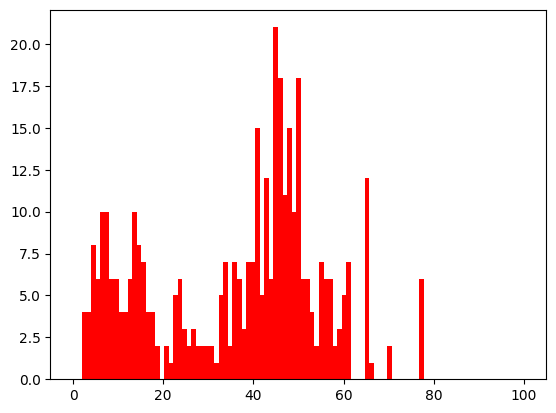

In [115]:
''' plot raw speed distribution '''
link_idx = 1045
link_speed = SCALER.inverse_transform(batch_x[:,:, link_idx, :])
plt.hist(torch.flatten(link_speed), np.linspace(0, 100, 100), color='red')

In [97]:
''' get a sample road time-series '''
sample_x_speed = SCALER.inverse_transform(batch_x[0,:,545, :])

In [98]:
sample_y_speed = batch_y[0,:,545, :]

In [99]:
sample_x_speed

tensor([[10.0000],
        [15.0000],
        [13.0000],
        [12.0000],
        [ 7.0000],
        [ 8.0000],
        [11.0000],
        [11.0000],
        [11.0000],
        [13.0000],
        [11.0000],
        [12.0000]])

In [100]:
sample_y_speed

tensor([[7.]])

In [ ]:
def masked_row_softmax(logits: torch.Tensor,
                       mask: torch.Tensor,
                       temperature: float = 1.0,
                       fallback_self_loop: bool = True) -> torch.Tensor:
    """
    Perform row-wise softmax only over entries where mask==1; others get prob 0.
    If a row has no allowed entries and fallback_self_loop=True, we set the diagonal
    mask to 1 for that row before softmax (so it becomes a self-loop).
    Shapes: logits, mask -> (B,N,N) or (1,N,N) for mask (will broadcast to B).
    """
    if mask is None:
        # standard row-softmax over all columns
        return F.softmax(logits / temperature, dim=-1)

    # Broadcast mask to (B,N,N)
    m = mask.bool()
    if m.dim() == 3 and logits.dim() == 3 and m.size(0) == 1:
        m = m.expand(logits.size(0), -1, -1)

    B, N, _ = logits.shape
    # Optionally ensure at least one allowed entry per row (to avoid all -inf → NaN)
    if fallback_self_loop:
        row_has_any = m.any(dim=-1)  # (B,N)
        if (~row_has_any).any():
            eye = torch.eye(N, device=logits.device, dtype=m.dtype).bool().unsqueeze(0)
            m = torch.where(~row_has_any.unsqueeze(-1) & eye, True, m)

    # Set disallowed positions to -inf so softmax gives ~0 there
    neg_inf = torch.finfo(logits.dtype).min
    masked_logits = torch.where(m, logits / temperature, neg_inf)

    # Numerically stable softmax: subtract row-max over allowed entries
    row_max = masked_logits.max(dim=-1, keepdim=True).values  # (B,N,1)
    exps = torch.exp(masked_logits - row_max) * m  # zero where disallowed
    denom = exps.sum(dim=-1, keepdim=True).clamp_min(1e-12)
    probs = exps / denom
    return probs  # (B,N,N), rows sum to 1 over allowed entries only

def masked_sigmoid(logits: torch.Tensor,
                   mask: torch.Tensor,
                   temperature: float = 1.0) -> torch.Tensor:
    """
    Independent sigmoid activation with masking.
    Shapes: logits, mask -> (B,N,N)
    """
    probs = torch.sigmoid(logits / temperature)
    if mask is not None:
        probs = probs * mask
    return probs


class TemporalNodeEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 64, out_dim: int = 64, bidirectional=False):
        super().__init__()
        self.gru = nn.GRU(input_size=in_dim, hidden_size=hidden,
                          batch_first=True, bidirectional=bidirectional)
        self.proj = nn.Linear(hidden*(2 if bidirectional else 1), out_dim)

    def forward(self, x_BTNC: torch.Tensor) -> torch.Tensor:
        B, T, N, C = x_BTNC.shape
        x = x_BTNC.permute(0, 2, 1, 3).reshape(B*N, T, C)   # (B*N,T,C)
        h, _ = self.gru(x)
        h = self.proj(h[:, -1])                             # (B*N,H)
        return h.view(B, N, -1)                             # (B,N,H)


class EdgeScorer(nn.Module):
    def __init__(self, node_dim: int, edge_feat_dim: int = 0, hidden: int = 128):
        super().__init__()
        in_d = 4*node_dim + edge_feat_dim      # [hi, hj, hi-hj, hi*hj, (+ e_ij)]
        self.mlp = nn.Sequential(
            nn.Linear(in_d, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, 1)
        )

    def forward(self, H_BNH: torch.Tensor, Efeat_BNNE: torch.Tensor | None = None) -> torch.Tensor:
        B, N, H = H_BNH.shape
        hi = H_BNH[:, :, None, :].expand(B, N, N, H)
        hj = H_BNH[:, None, :, :].expand(B, N, N, H)
        feats = [hi, hj, hi - hj, hi * hj]
        if Efeat_BNNE is not None:
            feats.append(Efeat_BNNE)
        Z = torch.cat(feats, dim=-1)
        return self.mlp(Z).squeeze(-1)  # (B,N,N)


class PropagationGraphLearner(nn.Module):
    """
    Learns a soft, directed propagation graph G (B,N,N) with masked row-softmax.
    Self-loops are allowed if the mask diagonal is 1.
    """
    def __init__(self, in_dim: int, node_dim: int = 64, edge_hidden: int = 128,
                 scorer_edge_feat_dim: int = 0, temperature: float = 1.0):
        super().__init__()
        self.encoder = TemporalNodeEncoder(in_dim, hidden=node_dim, out_dim=node_dim)
        self.scorer  = EdgeScorer(node_dim, edge_feat_dim=scorer_edge_feat_dim, hidden=edge_hidden)
        self.temperature = temperature

    def forward(self, x_BTNC: torch.Tensor,
                mask_M: torch.Tensor,                  # (1 or B, N, N) with 1=allowed (neighbors)
                edge_feats: torch.Tensor | None = None,
                fallback_self_loop: bool = True):
        H = self.encoder(x_BTNC)                        # (B,N,H)
        logits = self.scorer(H, edge_feats)             # (B,N,N), includes self logits
        soft = masked_row_softmax(logits, mask_M, self.temperature, fallback_self_loop)
        return soft  # (B,N,N)

In [74]:
B, T, N, C = 4, 12, 1212, 8
x = torch.randn(B, T, N, C)

learner = PropagationGraphLearner(
    in_dim=C,
    node_dim=64,
    edge_hidden=128,
    scorer_edge_feat_dim=0,     # set to E.shape[-1] if you pass edge features
    temperature=0.7,
)

In [77]:
soft_P = learner(x, mask_M=torch.tensor(endpoint_adj[0]), edge_feats=None)

In [78]:
soft_P

tensor([[[0.0000, 0.5018, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.4930, 0.0000, 0.5070,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3319, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.4966, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5003, 0.0000, 0.4997,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3311, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.5053, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.4964, 0.0000, 0.5036,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3318, 0.0000,  ..., 0.0000, 0.0000, 0.

In [48]:
import networkx as nx

In [55]:
def soft_tree_marginals(scores: torch.Tensor, mask_G: torch.Tensor, tau: float = 0.1):
    """
    Differentiable edge marginals for the random spanning tree distribution
    restricted to G, using Kirchhoff / Matrix-Tree theorem.

    scores : (N,N) torch, symmetric logits for edges
    mask_G : (N,N) torch/bool, 1 where edge allowed in G
    tau    : temperature; smaller -> sharper (closer to hard MST), but gradients get steeper

    Returns:
      P : (N,N) torch, symmetric in [0,1], expected incidence of each undirected edge.
    """
    N = scores.shape[0]
    sym_scores = 0.5 * (scores + scores.T)
    # Allowed, positive weights (zero elsewhere)
    W = torch.where(mask_G.bool(), torch.exp(sym_scores / tau), torch.zeros_like(sym_scores))
    W = W - torch.diag(torch.diag(W))  # zero diagonal
    W = 0.5 * (W + W.T)

    # Laplacian
    d = W.sum(dim=1)
    L = torch.diag(d) - W

    # Pseudoinverse (add tiny jitter for stability on GPU)
    # NOTE: For large N, use a Cholesky-based solver on the (N-1)x(N-1) cofactor instead.
    eps = 1e-6
    L_ = L + eps * torch.eye(N, device=L.device, dtype=L.dtype)
    L_pinv = torch.linalg.pinv(L_)

    # Effective resistance matrix R_ij = L^+_ii + L^+_jj - 2 L^+_ij
    diag = torch.diag(L_pinv).unsqueeze(0)  # shape 1xN
    R = diag + diag.T - 2.0 * L_pinv

    # Edge marginals
    P = W * R
    # Clean numerics/symmetry
    P = 0.5 * (P + P.T)
    P = torch.clamp(P, min=0.0, max=1.0)
    P = P - torch.diag(torch.diag(P))
    return P


In [57]:
N = 1212

In [58]:
scores = torch.nn.Parameter(torch.randn(N, N) * 0.1)

In [63]:
mst = soft_tree_marginals(scores, mask_G=torch.tensor(endpoint_adj[0]))

(array([ 12.,  14.,  18.,  46.,  68.,  82.,  68.,  72., 112.,  96., 114.,
        134., 138., 132., 126., 112., 168., 124., 110., 104., 142., 150.,
        132.,  82.,  94., 116., 116., 114., 106., 112., 108.,  90., 102.,
         96.,  68., 102., 100.,  78.,  96., 104.,  82.,  78.,  82.,  68.,
         64.,  62.,  70.,  64.,  56.,  82.,  52.,  48.,  68.,  54.,  72.,
         50.,  46.,  44.,  30.,  26.,  38.,  28.,  42.,  28.,  48.,  28.,
         26.,  22.,  26.,  30.,  20.,  32.,  28.,  34.,  16.,   8.,  16.,
         20.,  22.,   6.,  12.,   6.,  10.,  10.,  24.,  16.,  18.,  22.,
         18.,  12.,  10.,  20.,  14.,  26.,   8.,  18.,   4.,  26.,  16.,
        222.]),
 array([0.02739118, 0.03711727, 0.04684336, 0.05656945, 0.06629553,
        0.07602162, 0.08574771, 0.0954738 , 0.10519989, 0.11492597,
        0.12465207, 0.13437815, 0.14410424, 0.15383032, 0.16355641,
        0.1732825 , 0.1830086 , 0.19273467, 0.20246077, 0.21218686,
        0.22191295, 0.23163903, 0.24136512, 0.

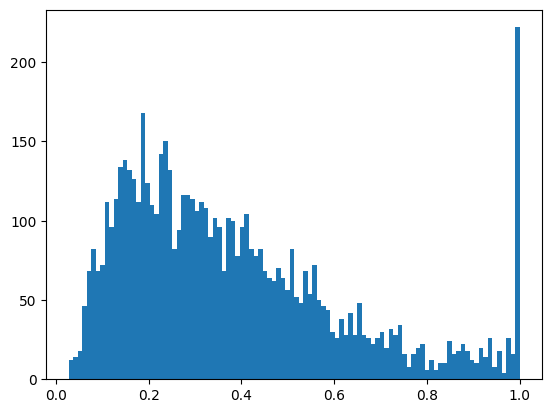

In [71]:
plt.hist(mst[[endpoint_adj[0]>0]].detach().numpy(), bins=100)

In [44]:
adj_mx[0]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [45]:
endpoint_adj[0]

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [46]:
diff = endpoint_adj[0] - adj_mx[0]

In [47]:
np.sum(diff[diff>0]), np.sum(diff[diff<0]), np.sum(adj_mx[0])

(4321, 0, 1865)

In [8]:
# ---------------------- set loss, optimizer, scheduler ---------------------- #
from functools import partial

model = partial(STGformer)
model = model(**cfg["model_args"], supports=supports)
model = model.to(DEVICE)
criterion = MaskedMAELoss()  # MaskedHuberLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg["lr"],
    weight_decay=cfg.get("weight_decay", 0),
    eps=cfg.get("eps", 1e-8),
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=cfg["milestones"],
    gamma=cfg.get("lr_decay_rate"),
    verbose=False,
)

/home/dachuan/anaconda3/envs/deep/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [11]:
# --------------------------- set model saving path -------------------------- #
save_path = f"../saved_models/"

model_files = glob.glob(os.path.join(save_path, f"{model_name}-{dataset}-*.pt"))
if not model_files:
    raise ValueError("No saved model found for testing.")
latest_model = max(model_files, key=os.path.getctime)
loaded_model = latest_model if path_to_Weight is None else path_to_Weight
print_log(f"Loading the latest model: {loaded_model}", log=log)
model.load_state_dict(torch.load(loaded_model))
model = model.to(DEVICE)

Loading the latest model: ../saved_models/STGformer-INRIX_MANHATTAN-2025-09-29-09-19-43.pt


In [12]:
# --------------------------- print model structure -------------------------- #

print_log("---------", model_name, "---------", log=log)
print_log(
    json.dumps(cfg, ensure_ascii=False, indent=4, cls=CustomJSONEncoder), log=log
)
print_log(
    summary(
        model,
        [
            cfg["batch_size"],
            cfg["in_steps"],
            cfg["num_nodes"],
            next(iter(trainset_loader))[0].shape[-1],
        ],
        verbose=0,  # avoid print twice
        device=DEVICE,
    ),
    log=log,
)
print_log(log=log)


--------- STGformer ---------
{
    "num_nodes": 1212,
    "in_steps": 12,
    "out_steps": 1,
    "train_size": 0.6,
    "val_size": 0.2,
    "time_of_day": false,
    "day_of_week": false,
    "lr": 0.001,
    "weight_decay": 0.0015,
    "milestones": [
        60,
        100,
        140,
        180
    ],
    "lr_decay_rate": 0.1,
    "batch_size": 32,
    "max_epochs": 300,
    "early_stop": 30,
    "use_cl": false,
    "cl_step_size": 2500,
    "model_args": {
        "num_nodes": 1212,
        "in_steps": 12,
        "out_steps": 1,
        "steps_per_day": 288,
        "input_dim": 1,
        "output_dim": 1,
        "input_embedding_dim": 24,
        "tod_embedding_dim": 0,
        "dow_embedding_dim": 0,
        "adaptive_embedding_dim": 12,
        "kernel_size": [
            1
        ],
        "num_heads": 4,
        "num_layers": 6,
        "dropout": 0.1,
        "dropout_a": 0.35
    }
}
Layer (type:depth-idx)                        Output Shape              Param #

In [13]:
# --------------------------- evaluate model performance --------------------------- #
test_model(model, testset_loader, log=log)

--------- Test ---------


100%|██████████| 656/656 [00:33<00:00, 19.65it/s]


All Steps RMSE = 5.18408, MAE = 2.50651, MAPE = 18.47258
Step 1 RMSE = 5.18408, MAE = 2.50651, MAPE = 18.47258
Inference time: 33.41 s


In [14]:
# --------------------------- inference graph --------------------------- #
graph = inference_graph(model)

### Inference wavelets

In [45]:
import types

@torch.no_grad()
def average_U_instance(model, loader, steps=8):
    device = next(model.parameters()).device
    model.eval()

    # 1) Find the noflayer instance actually used
    wave = model.attn_layers_s[0].locals.wavelet_layer  # your noflayer instance

    # 2) Keep originals
    orig_attention = wave.attention

    # 3) Tape + tapped attention
    TAPE = {'Ulist': []}
    def tapped_attention(self, x_BTNC, A_TNN):
        U, P, A_BTNN = orig_attention(x_BTNC, A_TNN)  # call the real thing
        TAPE['Ulist'].append(U.detach().cpu())
        return U, P, A_BTNN

    # 4) Monkey-patch the INSTANCE (bind with MethodType)
    wave.attention = types.MethodType(tapped_attention, wave)

    U_acc, n = None, 0
    it = iter(loader)
    try:
        for _ in range(steps):
            batch = next(it)
            batch_x = batch[0] if isinstance(batch, (list, tuple)) else batch
            batch_x = batch_x.to(device)

            _ = model(batch_x)  # this will now push U’s into TAPE

            for U in TAPE['Ulist']:
                Umean = U.mean(0).mean(0).numpy()  # (T,N,N) → (N,N)
                U_acc = Umean if U_acc is None else U_acc + Umean
                n += 1
            TAPE['Ulist'].clear()
    except StopIteration:
        pass
    finally:
        # 5) Restore original method no matter what
        wave.attention = orig_attention

    if n == 0:
        raise RuntimeError("average_U_instance: never captured any U. "
                           "Check that the forward actually calls wavelet_layer.attention.")
    return U_acc / n  # Ubar (N,N)

In [17]:
# --------------------------- inference wavelets --------------------------- #
def get_coe_cheb(wave):
    coe  = torch.sigmoid(wave.temp).detach().cpu().numpy()
    cheb = torch.sigmoid(wave.cheb).detach().cpu().numpy()
    if wave.alpha_ is not None:  # override if alpha_ is set
        a1 = float(wave.alpha_)
        a2 = float(wave.alpha_)
    else:
        a1 = float(coe[1])
        a2 = float(coe[2])
    return a1, a2, cheb

def compute_betas(K, a1, a2, cheb, r0):
    betas = []
    r_s = float(r0)
    for s in range(K):  # s=0..K-1 => k=s+1
        w_s = 1.0 - (1.0 - a1) * r_s
        beta = (1.0 - a2) * (a2 ** (K-1 - s)) * w_s
        betas.append(beta)
        if s < K-1 and len(cheb) > s:
            r_s *= float(cheb[s])
    return np.array(betas, dtype=float)  # shape (K,)

def poly_operator(Ubar, betas, symmetrize=True):
    U = 0.5*(Ubar+Ubar.T) if symmetrize else Ubar
    N = U.shape[0]
    M = np.zeros((N,N), dtype=float)
    Uk = np.eye(N)
    for k, beta_k in enumerate(betas, start=1):
        Uk = Uk @ U
        M += beta_k * Uk
    return M

def centered_poly_operator(Ubar, betas):
    U = 0.5*(Ubar+Ubar.T)
    # stationary distribution ~ principal eigenvector (normalize to sum 1)
    vals, vecs = np.linalg.eigh(U)
    v = vecs[:, -1]; pi = np.abs(v); pi = pi / pi.sum()
    J = np.ones((U.shape[0],1)) @ pi[None,:]  # 1 * pi^T

    M = np.zeros_like(U)
    Uk = np.eye(U.shape[0])
    for k, beta in enumerate(betas, start=1):
        Uk = Uk @ U
        M += beta * (Uk - J)          # <-- remove rank-1 limit each hop
    return M

def poly_operator_unsym(Ubar, betas):
    M = np.zeros_like(Ubar)
    Uk = np.eye(Ubar.shape[0])
    for k, beta in enumerate(betas, start=1):
        Uk = Uk @ Ubar
        M += beta * Uk
    return M

def row_topk(U, k=8):
    U2 = U.copy()
    idx = np.argsort(U2, axis=1)[:, :-k]
    U2[np.arange(U2.shape[0])[:,None], idx] = 0.0
    # renormalize rows
    rs = U2.sum(axis=1, keepdims=True); rs[rs==0]=1
    return U2/rs




In [18]:
wave = model.attn_layers_s[0].locals.wavelet_layer
a1, a2, cheb = get_coe_cheb(wave)
betas = compute_betas(1, a1, a2, cheb, 0.5)
Ubar = average_U_instance(model, trainset_loader, steps=8)
Ubar_k = row_topk(Ubar, k=8)
m_indices = poly_operator_unsym(Ubar_k, betas)

AttributeError: 'GraphPropagate' object has no attribute 'wavelet_layer'

In [67]:
m_indices.min()

0.00030940594

(array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.212e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.212e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.212e+03],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.212e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.212e+03],
        [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         1.211e+03]]),
 array([-2.18278728e-11, -2.13913158e-11, -2.09547588e-11, -2.05182000e-11,
        -2.00816429e-11, -1.96450859e-11, -1.92085289e-11, -1.87719701e-11,
        -1.83354130e-11, -1.78988560e-11, -1.74622990e-11, -1.70257402e-11,
        -1.65891832e-11, -1.61526261e-11, -1.57160691e-11, -1.52795103e-11,
        -1.48429533e-11, -1.44063962e-11, -1.39698383e-11, -1.35332813e-11,
        -1.30967234e-11, -1.26601663e-11, -1.22236084e-11, -1.178

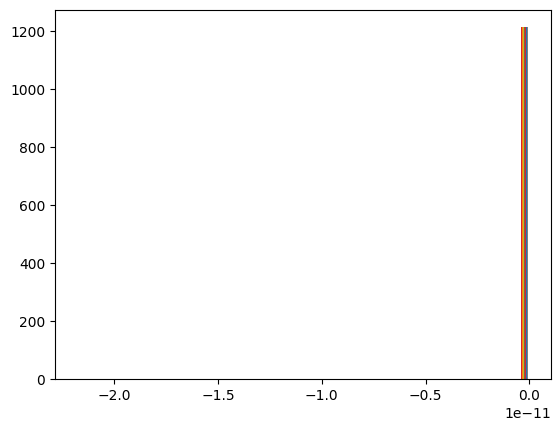

In [60]:
plt.hist(m_indices, bins=50)

In [48]:
m_indices.max()

0.0003094059502473101

In [49]:
m_indices.min()

0.00030940592841943726